In [7]:
%matplotlib inline

/usr/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-11-12 17:26:58.803692. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [8]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier

/usr/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-11-12 17:26:59.012062. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [9]:
def gini(actual, pred):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)


def gini_normalized(actual, pred):
    return gini(actual, pred) / gini(actual, actual)

/usr/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-11-12 17:26:59.402383. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


#### Load data 

In [17]:
data = pd.read_csv("../data/train.csv", na_values=[-1, -1.0], index_col="id")

In [18]:
X, y = data.loc[:, data.columns != "target"], data.target

#### Preprocess 

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

/usr/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


#### Under-Sampling 

In [20]:
%%time
resampler = RandomUnderSampler()
indexes = X_train.index.values.reshape(-1, 1)
index_res, y_res = resampler.fit_sample(indexes, y_train)

model = XGBClassifier()
model.fit(X_train.loc[index_res.flatten(), :], y_res)
y_pred = model.predict(X_test)

under_gini = gini_normalized(y_test, y_pred)
print(under_gini)

0.187199955807
CPU times: user 4.45 s, sys: 53.3 ms, total: 4.51 s
Wall time: 4.5 s


####  Over-Sampling

In [21]:
%%time
resampler = SMOTE()
X_res, y_res = resampler.fit_sample(X_train.fillna(X_train.median()), y_train)
model = XGBClassifier()
model.fit(X_res, y_res)
y_pred = model.predict(X_test.fillna(X_test.median()).values)
over_gini = gini_normalized(y_test, y_pred)
print(over_gini)

0.0041320834924
CPU times: user 3min 40s, sys: 347 ms, total: 3min 40s
Wall time: 3min 40s


####  Class Weights in XGBoost 

In [22]:
%%time
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
model = XGBClassifier(class_weight=class_weights)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
xgb_gini = gini_normalized(y_test, y_pred)
print(xgb_gini)

0.0041320834924
CPU times: user 1min 22s, sys: 153 ms, total: 1min 22s
Wall time: 1min 22s


#### Results 

<Container object of 3 artists>

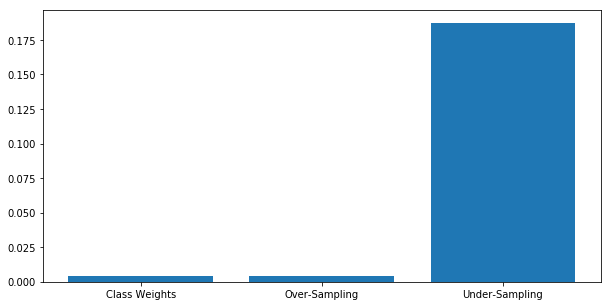

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(["Over-Sampling", "Under-Sampling", "Class Weights"], [over_gini, under_gini, xgb_gini])